# PhD Student Mental Health Project

## Overview

This notebook contains analysis of survey data conducted by Shift Learning on PhD students. The project uses multiple machine learning models such as logistic regression and decision trees to draw insights into what risk factors contribute to mental health problems in PhD students and make recommendations on how to improve. The project also include a predictive model that can be deployed to continuously monitor student mental health.

## Business Problem

PhD students are at high risk of mental health issues and have a high suicide rate. This project aims to help academia understand the risk factors in order to systematically improve student’s overall mental health. This project also makes recommendations on how to set up preventative measures for mental health issues among students.

#### End Users:
- Universities, research facilities, school mental health counselors

#### True Business Problem:

- Understand risk factors that contributes to PhD students needing help for anxiety and depression.
- create a model that helps to identify students who might need help

#### Context:
- False positive: predict that a student need help for anxiety/depression when they don't 
    - Outcome: trouble and disturbance to the student
- False negative: predict that a student doesn't need help for anxiety/depression when they actually do
    - Outcome: student not getting the help that they need

#### Model Evaluation

We will be focusing on recall because we want to minimize false negative. 

## Data Understanding

The data is aggregated by surveying and interviewing 6,320 current PhD students all over the world in 2019. There are around 60 questions about their personal information and their opinions and concerns about their PhD program.
Important questions include age, country of origin, country of study, whether/by whom they were bullied, whether/reason they need to work outside of their program, whether/which kind of discrimination the student faced, their career expectations, worries about the program/their future, etc.

We are modeling on the assumption that if students need help with anxiety and/or depression, they would ask for it. 

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import sklearn modeling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# import CatBoost tools
import catboost
from catboost import Pool
from catboost import CatBoostClassifier

# import my own evaluate function
from utils import evaluate

# import and activate warning suppression tool
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define a function to print out information of a column
def info(label):
    '''
    input string of column name
    output comprehensive analysis of the column
    '''
    print(f'column name: {label}')
    print('     ')
    print(f'Question: {df[label][0]}')
    print('     ')
    print(f'number of null values: {df[label].isna().sum()}')
    print('     ')
    print('Value Count:')
    
    print(df[label].value_counts())

In [3]:
# function for cleaning and adding the column to list for inferential model
def process(column_name,dictionary):
    inf_df[column_name]=inf_df[column_name].map(dictionary)
    inf_col.append(column_name)

### EDA

In [4]:
# load dataframe
df=pd.read_csv('data.csv',dtype='str')

In [ ]:
# check the dataframe
# output cleared because it's too long for github
df

The first row is the questions.

In [6]:
# check the size of the dataset
df.shape

(6813, 274)

The dataset has 6812 data points and 274 columns. 

In [ ]:
# check column names
# output cleared because it's too long for github
list(df.columns)

Survey questions start from the 10th column.

In [ ]:
# print out a list of the questions
# output cleared because it's too long for github
question_list=list(df.columns)[9:]
for q in question_list:
    print('********')
    print(q)
    print(df[q][0])

Comprehensive exploratory data analysis was done by the original survey conductor and can be found [here](https://figshare.com/s/74a5ea79d76ad66a8af8?file=18543281).

#### Data Limitation

**Bias:**

Data can be skewed towards overrepresented classes, notably Caucasian students.

![Demographic](images/demographic.png)

**Target:**

Assume people who needs help would ask. Even though it would vastly underestimate the number of people who need help, it is the best metric we have now.

**Question Design:**

Survey questions are not specifically directed towards mental health, so the amount of information it can give is limited.

### Target

Our target column is Q28

In [9]:
# check values for target
df['Q28'].value_counts()

No                                                                          4083
Yes                                                                         2429
Prefer not to say                                                            292
Have you ever sought help for anxiety or depression caused by PhD study?       1
Name: Q28, dtype: int64

In [10]:
df['Q28'].value_counts(normalize=True)

No                                                                          0.600000
Yes                                                                         0.356943
Prefer not to say                                                           0.042910
Have you ever sought help for anxiety or depression caused by PhD study?    0.000147
Name: Q28, dtype: float64

There are 4083 Nos and 2429 Yeses. There's a little bit of class imbalance, but not too bad.

In [11]:
# check null values
df['Q28'].isna().sum()

8

There are not many "prefer not to say"s or null values, so we can safely drop them.

In [ ]:
# drop the rows that have null values in our target column
# output cleared because it's too long for github
df=df.dropna(subset=['Q28'])
df

In [13]:
# drop "Prefer not to say"s
df=df[df['Q28']!='Prefer not to say']

In [14]:
# make a dictionary for mapping target column
dict_target={'Yes': 1, 'No': 0}

In [15]:
# map target column into numeric values
df['Q28']=df['Q28'].map(dict_target)

#### Features

There are two parts to this problem:
- inferential modeling:
    - figure out the risk factors for mental health issues in PhD students
- predictive modeling:
    - a model that can be put into use 

For these two approaches we need different data cleaning methods.

### Baseline Understanding

In [16]:
df['Q28'][1:].value_counts(normalize=True)

0.0    0.626996
1.0    0.373004
Name: Q28, dtype: float64

If we predict the majority class of not going to need help for anxiety/depression as a result of PhD study (assuming that if people need help, they ask for help), we will be right 62.7% of the time.

### Inferential Modeling 

For this method, I'm going to pick out features that I think might be most relevant to mental health based on common sense and clean them up individually.

The survey questions and answers can be found [here](https://figshare.com/s/74a5ea79d76ad66a8af8?file=18543278).

In [17]:
# create a new list for all the columns that we'll be using for inferential modeling
inf_col=[]

In [18]:
# create a new df for inferential modeling by dropping the non-question columns
inf_df=df.drop(columns=df.columns[:9])

In [ ]:
# check dataframe
# output cleared because it's too long for github
inf_df

**Dual Degree**

In [20]:
info('Q1')

column name: Q1
     
Question: Which, if any, of the following degrees are you currently studying for?
     
number of null values: 0
     
Value Count:
Doctorate degree (PhD/DPhil/MD)                                            6294
Dual doctorate degree (MD-PhD, PhD-PhD or other combination)                218
Which, if any, of the following degrees are you currently studying for?       1
Name: Q1, dtype: int64


In [21]:
# create dictionary for converting values into numbers
dict_Q1={'Doctorate degree (PhD/DPhil/MD)': 0, 
         'Dual doctorate degree (MD-PhD, PhD-PhD or other combination)': 1, 
         'Which, if any, of the following degrees are you currently studying for?':'dual_degree'}

In [22]:
# change values in column Q1
inf_df['Q1']=inf_df['Q1'].replace(dict_Q1)

In [23]:
# add processed column to list
inf_col.append('Q1')

The previous two steps are going to be repeated throughout the inferential modeling cleaning process so I'll write a function for it.

**Home Country**

In [24]:
info('Q4')

column name: Q4
     
Question: Are you studying in the country you grew up in?   
     
number of null values: 0
     
Value Count:
Yes                                                   4153
 No                                                   2359
Are you studying in the country you grew up in?          1
Name: Q4, dtype: int64


In [25]:
# create dictionary for value mapping
dict_Q4={'Yes':1, 
         ' No':0,        
         'Are you studying in the country you grew up in? \xa0 ': 'home country'}

In [26]:
# process the column
process('Q4',dict_Q4)

**Ouside Job**

In [27]:
info('Q13')

column name: Q13
     
Question: Do you have a job alongside your studies?
     
number of null values: 0
     
Value Count:
No                                           5249
Yes                                          1263
Do you have a job alongside your studies?       1
Name: Q13, dtype: int64


In [28]:
# create dictionary for value mapping
dict_Q13={'Yes ':1, 
          'No':0, 
          'Do you have a job alongside your studies?': 'job'}

In [29]:
# process the column
process('Q13',dict_Q13)

**Bullying**

In [30]:
info('Q31')

column name: Q31
     
Question: Do you feel that you have experienced bullying in your PhD program?
     
number of null values: 7
     
Value Count:
No                                                                     4902
Yes                                                                    1388
Prefer not to say                                                       215
Do you feel that you have experienced bullying in your PhD program?       1
Name: Q31, dtype: int64


In [31]:
# create dictionary for value mapping
dict_Q31={'Yes':1, 
          'No': 0, 
          'Prefer not to say': 2, 
          'Do you feel that you have experienced bullying in your PhD program?': 'bullying'}

In [32]:
# process column
process('Q31',dict_Q31)

**discrimination/harrassment**

In [33]:
info('Q34')

column name: Q34
     
Question: Do you feel that you have experienced discrimination or harassment in your PhD program?
     
number of null values: 24
     
Value Count:
No                                                                                         4937
Yes                                                                                        1334
Prefer not to say                                                                           217
Do you feel that you have experienced discrimination or harassment in your PhD program?       1
Name: Q34, dtype: int64


In [34]:
# create dictionary for value mapping
dict_Q34={'Yes':1, 
          'No': 0, 
          'Prefer not to say': 2, 
          'Do you feel that you have experienced discrimination or harassment in your PhD program?': 'discrimination/harrassment'}

In [35]:
# process column
process('Q34',dict_Q34)

**Satisfaction**

In [36]:
info('Q19.a')

column name: Q19.a
     
Question: How satisfied are you with your PhD experience?
     
number of null values: 0
     
Value Count:
6                                                  2085
5                                                  1908
4 = Neither satisfied nor dissatisfied              717
3                                                   659
7 = Extremely satisfied                             592
2                                                   360
1 = Not at all satisfied                            191
How satisfied are you with your PhD experience?       1
Name: Q19.a, dtype: int64


Satisfaction is on a scale of 1 to 7, not at all satisfied to extremely satisfied. So the values just need to be reduced to numbers. 

In [37]:
# process the column values
inf_df['Q19.a'][1:]=inf_df['Q19.a'][1:].map(lambda x:int(x[0]))
# change the value of the first row 
inf_df['Q19.a'][0]='satisfaction'
# add the column to our column list
inf_col.append('Q19.a')

**Work Hours**

In [38]:
info('Q24')

column name: Q24
     
Question: On average, how many hours a week do you typically spend on your PhD programme?
     
number of null values: 0
     
Value Count:
41-50 hours                                                                        1785
51-60 hours                                                                        1609
31-40 hours                                                                         783
61-70 hours                                                                         774
71-80 hours                                                                         425
More than 80 hours                                                                  328
Less than 11 hours                                                                  287
21-30 hours                                                                         274
11-20 hours                                                                         247
On average, how many hours a week do you typi

For this column, we can just take the middle of the range and cap it at 81 hours for simplicity. 

In [39]:
# create dictionary for value mapping
dict_Q24={'41-50 hours': 45, 
          '51-60 hours': 55, 
          '31-40 hours': 35, 
          '61-70 hours': 65, 
          '71-80 hours': 75, 
          'More than 80 hours':81, 
          'Less than 11 hours': 5, 
          '21-30 hours': 25, 
          '11-20 hours': 15, 
          'On average, how many hours a week do you typically spend on your PhD programme?': 'hours_worked'}

In [40]:
# process the column
process('Q24', dict_Q24)

**Gender**

In [41]:
info('Q57')

column name: Q57
     
Question: Are you…
     
number of null values: 0
     
Value Count:
Female (including trans female)    3298
Male (including trans male)        3149
Prefer not to say                    35
Gender queer / Non binary            30
Are you…                              1
Name: Q57, dtype: int64


In [42]:
# create dictionary for value mapping
dict_Q57={'Female (including trans female)':0, 
          'Male (including trans male)': 1, 
          'Prefer not to say': 2, 
          'Gender queer / Non binary': 3, 
          'Are you…': 'gender'}

In [43]:
# process the column
process('Q57',dict_Q57)

**Age**

In [44]:
info('Q56')

column name: Q56
     
Question: What is your age?
     
number of null values: 0
     
Value Count:
25 - 34              5019
18 - 24               789
35 - 44               530
45 - 54               103
55 - 64                35
Prefer not to say      23
65 or over             13
What is your age?       1
Name: Q56, dtype: int64


Similar to the work hours column, I'll take the middle value and cap it at 65. Use majority class to fill in value for "prefer not to say".

In [45]:
# create dictionary for value mapping
dict_Q56={'25 - 34':30, 
          '18 - 24':21, 
          '35 - 44':40, 
          '45 - 54': 50, 
          '55 - 64': 60, 
          'Prefer not to say': 30, 
          '65 or over': 65, 
          'What is your age?': 'age'}

In [46]:
# process the column
process('Q56',dict_Q56)

**Expected Unemployment Time**

In [47]:
info('Q42')

column name: Q42
     
Question: After completing your PhD, how long do you think it will take you to find a permanent (non-trainee) position?
     
number of null values: 0
     
Value Count:
Less than a year                                                                                                 1712
1 to 2 years                                                                                                     1258
3 to 6 years                                                                                                     1161
2 to 3 years                                                                                                     1046
Unsure                                                                                                            885
More than 6 years                                                                                                 450
After completing your PhD, how long do you think it will take you to find a permanent (non-trainee)

Similar to the age column, I'll take the middle value and cap it at 6. Use most frequent class to fill in value for "Unsure".

In [48]:
# create dictionary for value mapping
dict_Q42={'Less than a year': 0.5, 
          '1 to 2 years': 1.5, 
          '3 to 6 years': 4.5, 
          '2 to 3 years': 2.5, 
          'Unsure': 0.5, 
          'More than 6 years': 6, 
          'After completing your PhD, how long do you think it will take you to find a permanent (non-trainee) position?': 'expected_unemployment_time'}

In [49]:
# process the column
process('Q42',dict_Q42)

In [50]:
# check the column list now
inf_col

['Q1', 'Q4', 'Q13', 'Q31', 'Q34', 'Q19.a', 'Q24', 'Q57', 'Q56', 'Q42']

In [51]:
# take out this subset
inf_df=inf_df[inf_col]

In [ ]:
# check dataframe
# output cleared because it's too long for github
inf_df

In [53]:
# make the first row column names
inf_df.columns = inf_df.iloc[0]
# drop the first row
inf_df=inf_df.drop([0])

In [54]:
# fill na for 'job', 'bullying', and 'discrimination/harrassment'
# assume all nulls are 'prefer not to say'
inf_df['bullying'].fillna(value=2,inplace=True)
inf_df['discrimination/harrassment'].fillna(value=2,inplace=True)

In [55]:
# make all the data floats
inf_df=inf_df.astype(float)

In [ ]:
# check dataframe
# output cleared because it's too long for github
inf_df

#### Train Test Split (Inferential)

In [57]:
X_inf=inf_df
y_inf=df['Q28'][1:]
X_tr_inf, X_test_inf, y_tr_inf, y_test_inf = train_test_split(X_inf, y_inf, random_state=42)
X_train_inf, X_val_inf, y_train_inf, y_val_inf = train_test_split(X_tr_inf, y_tr_inf, random_state=42)

### Inferential Modeling

### Logistic Regression

#### Logistic Regression on Scaled Data for Feature Importance

In [58]:
# instantiate scaler
scaler=StandardScaler()
# fit scaler on training data and transform it
X_train_inf_scaled=scaler.fit_transform(X_train_inf)
# transform validation and test set
X_val_inf_scaled=scaler.transform(X_val_inf)
X_test_inf_scaled=scaler.transform(X_test_inf)

In [59]:
# instantiate and fit logistic regression on scaled data
lr_scaled=LogisticRegression()
lr_scaled.fit(X_train_inf_scaled,y_train_inf)

LogisticRegression()

Accuracy Score:
Train - 0.6699426699426699
Test - 0.6298116298116299
  
Precision Score:
Train - 0.6080910240202275
Test - 0.0
  
Recall Score: 
Train - 0.34855072463768116
Test - 0.0
  
F1 Score: 
Train - 0.44311377245508987
Test - 0.0
  
ROC_AUC: 
Train - 0.6063822392351786
Test - 0.5
  
  
Confusion matrix for test data


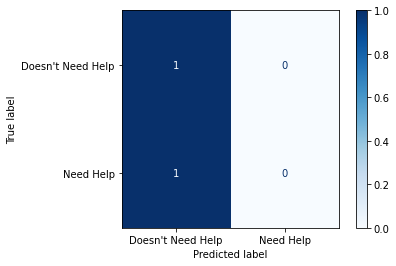

In [60]:
evaluate(lr_scaled,X_train_inf_scaled,y_train_inf, X_val_inf, y_val_inf)

In [61]:
# print out coefficient of the logistic regression model in a dataframe
coef_lr_scaled=pd.DataFrame(data=lr_scaled.coef_, columns=X_train_inf.columns).T
coef_lr_scaled

,0
0,
dual_degree,-0.000203
home country,-0.005066
job,-0.025679
bullying,0.293277
discrimination/harrassment,0.158266
satisfaction,-0.388380
hours_worked,0.011505
gender,-0.269279
age,-0.114616


In [62]:
# add a log odds column to this dataframe
coef_lr_scaled['log_odds']=coef_lr_scaled[0].map(lambda x:np.exp(x))
coef_lr_scaled

,0,log_odds
0,,
dual_degree,-0.000203,0.999797
home country,-0.005066,0.994947
job,-0.025679,0.974647
bullying,0.293277,1.340814
discrimination/harrassment,0.158266,1.171478
satisfaction,-0.388380,0.678154
hours_worked,0.011505,1.011572
gender,-0.269279,0.763930
age,-0.114616,0.891708


By scaling the data, we can see that bullying has the most impact on the model result. Now let's do a logistic regression on unscaled data to figure out the impact of this feature in terms of actual numbers.

#### Logistic Regression on Unscaled Data for Numerical Impact

Accuracy Score:
Train - 0.6693966693966694
Test - 0.6552006552006552
  
Precision Score:
Train - 0.6076433121019108
Test - 0.5584905660377358
  
Recall Score: 
Train - 0.3456521739130435
Test - 0.3274336283185841
  
F1 Score: 
Train - 0.44064665127020786
Test - 0.41283124128312415
  
ROC_AUC: 
Train - 0.6053709840217867
Test - 0.5876439923127381
  
  
Confusion matrix for test data


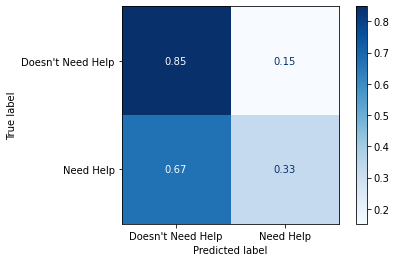

In [63]:
# instantiate logistic regression object
lr=LogisticRegression()
# fit the logistic regression
lr.fit(X_train_inf, y_train_inf)
# evaluate the model
evaluate(lr,X_train_inf,y_train_inf,X_val_inf,y_val_inf)

In [64]:
# print out coefficient of the logistic regression model in a dataframe
coef_lr=pd.DataFrame(data=lr.coef_, columns=X_train_inf.columns).T
coef_lr

,0
0,
dual_degree,-0.034009
home country,-0.005423
job,-0.071843
bullying,0.555394
discrimination/harrassment,0.302487
satisfaction,-0.264291
hours_worked,0.000697
gender,-0.500226
age,-0.020396


In [65]:
# add a log odds column to this dataframe
coef_lr['log_odds']=coef_lr[0].map(lambda x:np.exp(x))

In [66]:
coef_lr

,0,log_odds
0,,
dual_degree,-0.034009,0.966562
home country,-0.005423,0.994592
job,-0.071843,0.930677
bullying,0.555394,1.742628
discrimination/harrassment,0.302487,1.353221
satisfaction,-0.264291,0.767750
hours_worked,0.000697,1.000698
gender,-0.500226,0.606394
age,-0.020396,0.979811


**Interpretation**

holding everything else constant, the odds of needing help for anxiety and depression for students that are bullied (bullied = 1)over the odds of needing help for anxiety and depression for students that are not bullied (bullied = 0) is exp(.68) = 1.97.  In terms of percent change, we can say that the odds for getting anxiety and depression for students that are bullied are 97% higher than the odds for students that are not bullied.

#### Decision Tree

Accuracy Score:
Train - 0.6661206661206661
Test - 0.6437346437346437
  
Precision Score:
Train - 0.6288998357963875
Test - 0.5384615384615384
  
Recall Score: 
Train - 0.27753623188405796
Test - 0.26327433628318586
  
F1 Score: 
Train - 0.3851181498240322
Test - 0.3536404160475483
  
ROC_AUC: 
Train - 0.5892718391132948
Test - 0.5653172721728024
  
  
Confusion matrix for test data


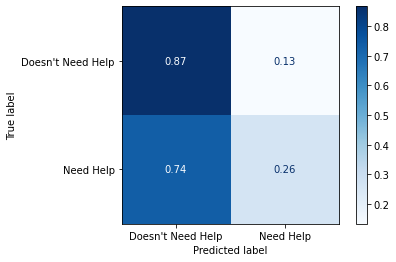

In [67]:
# instantiate, fit and evaluate decision tree model
dt=DecisionTreeClassifier(max_depth=3,random_state=42)
dt.fit(X_train_inf,y_train_inf)
evaluate(dt,X_train_inf,y_train_inf,X_val_inf,y_val_inf)

In [68]:
#print out feature importance of the decision tree model in a dataframe
fi_dt=pd.DataFrame(data=dt.feature_importances_, index=X_train_inf.columns)
fi_dt

,0
0,
dual_degree,0.000000
home country,0.000000
job,0.000000
bullying,0.511641
discrimination/harrassment,0.056412
satisfaction,0.272708
hours_worked,0.000000
gender,0.159238
age,0.000000


**Interpretation**

Decision tree confirms that bullying is the most important contributor to whether a student needs help for anxiety/depression.

### Predictive Modeling

Drop columns that are totally non-related: 

There are two types of columns that needs dropping:
- columns that starts with "ID.", these are the administrative columns of when and how the survey is done.
- columns starting from Q60 are also administrative columns
- columns that are 'If other, please specify'
- columns that give away the answer, which is 'Q29' : Did you seek help for anxiety or depression within your institution? 

In [69]:
# create a list for columns that needs dropping and loop through all columns to find them
drop_list=[]
for c in list(df.columns):
    if c[:2]=='ID':
        drop_list.append(c)
    elif c[:2]=='Q6':
        drop_list.append(c)
    elif df[c][0]=='If other, please specify':
        drop_list.append(c)

In [ ]:
# check drop list
# output cleared because it's too long for github
drop_list

In [ ]:
# add question 29 because it gives out the answer
# output cleared because it's too long for github
drop_list.append('Q29')
drop_list

In [72]:
# add question 55 because it's a another short answer column and we are not dealing with natural language processing in this project
drop_list.append('Q55')

In [73]:
# create dataframe for predictive modeling
df_pred=df.drop(columns=drop_list)

In [ ]:
# fill all null values with 0
# output cleared because it's too long for github
df_pred.fillna(0)

In [75]:
# convert data type to string for catboost
df_pred=df_pred.astype('str')

### Train Test Split

In [76]:
# separate X and y, drop the first column because they are questions
X=df_pred.drop('Q28', axis=1)
X=X.drop(index=1)
y=df['Q28'][1:]

In [77]:
# train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, random_state=42)

### CatBoost

**Untuned CatBoost**

In [78]:
# instantiate catboost object
cb=CatBoostClassifier(random_state=42, silent=True)

In [ ]:
# make a list for categorical features
# output cleared because it's too long for github
cat_features = X.columns[np.where(X.dtypes != float)[0]].values.tolist()
print(cat_features)

In [80]:
# fit the model on training set
cb.fit(X_train,y_train, cat_features=cat_features)

In [81]:
# get feature importance for catboost model
cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Q15.m,6.113318
1,Q57,3.017581
2,Q30.a,2.657536
3,Q31,2.553894
4,Q54:4,2.158595
...,...,...
221,Q58:5,0.022251
222,Q35:5,0.019389
223,Q2,0.000000
224,Q16,0.000000


Accuracy Score:
Train - 0.815997815997816
Test - 0.7125307125307125
  
Precision Score:
Train - 0.8268518518518518
Test - 0.6463768115942029
  
Recall Score: 
Train - 0.6471014492753623
Test - 0.49336283185840707
  
F1 Score: 
Train - 0.7260162601626016
Test - 0.5595984943538268
  
ROC_AUC: 
Train - 0.7825958407130207
Test - 0.6673576187900618
  
  
Confusion matrix for test data


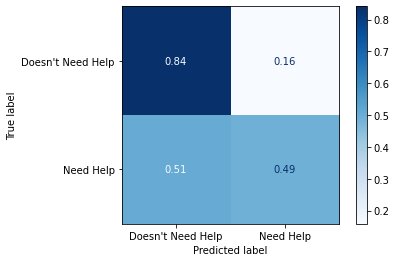

In [82]:
evaluate(cb,X_train,y_train,X_val,y_val)

The untuned catboost model is overfitted because the training accuracy is way higher than validation set accuracy.

**Tune CatBoost by Eliminating Noise Columns**

In [ ]:
# code adapted from Matthew Turner, his github link (https://github.com/austint1121/Undiagnosed-ADHD-Identification)

# output cleared because it's too long for github

# Select categorical features by selecting anything columns that aren't a float
categorical_features_indices = list(np.where(X_train.dtypes != float)[0])

# create catboost pool as input for this new model, select X, and y, specifying categorical columns
data = Pool(X_train, y_train, cat_features=categorical_features_indices)

# Instantiate model
model = CatBoostClassifier(random_state = 42)

# select features
summary = model.select_features(
    data,
    features_for_select=categorical_features_indices, 
    num_features_to_select=5, 
    steps=3,
    algorithm=catboost.EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=catboost.EShapCalcType.Regular,
    train_final_model=False,
    verbose=False
)

Train a new model that eliminates all the feature catboost found to be redundant.

In [ ]:
# output cleared because it's too long for github

# Instantiate model
new_cb = CatBoostClassifier(random_state= 42)

# select features and train new model with those features
summary = new_cb.select_features(
    data,
    features_for_select=categorical_features_indices, 
    num_features_to_select=5, 
    steps=5,
    algorithm=catboost.EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=catboost.EShapCalcType.Regular,
    train_final_model=True,
    verbose=False
)

Accuracy Score:
Train - 0.7654927654927655
Test - 0.6912366912366913
  
Precision Score:
Train - 0.7592039800995025
Test - 0.6132930513595166
  
Recall Score: 
Train - 0.5528985507246377
Test - 0.4491150442477876
  
F1 Score: 
Train - 0.639832285115304
Test - 0.5185185185185185
  
ROC_AUC: 
Train - 0.72344883734217
Test - 0.6413325546336467
  
  
Confusion matrix for test data


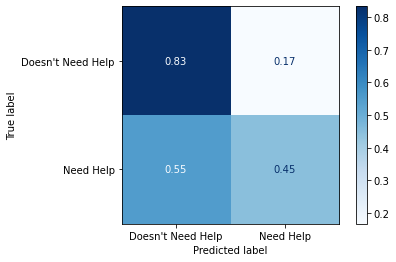

In [85]:
evaluate(new_cb,X_train,y_train,X_val,y_val)

The model is not overfitted.

#### Gridsearch CatBoost

Try gridsearch to see if there's an improvement.

In [86]:
# set up dictionary for parameters
cb_param={'learning_rate':[0.01,0.1,0.5],
          'depth':[3,7,10],
          'l2_leaf_reg':[1,5,9]}

In [ ]:
# output cleared because it's too long for github

# instantiate model object
gridsearch_cb=CatBoostClassifier(random_state=42)
# fit data to model object using gridsearch
result=gridsearch_cb.grid_search(cb_param, data, calc_cv_statistics=True, search_by_train_test_split=True, verbose=False)

Accuracy Score:
Train - 0.8416598416598416
Test - 0.7084357084357085
  
Precision Score:
Train - 0.8367003367003367
Test - 0.6263157894736842
  
Recall Score: 
Train - 0.7202898550724638
Test - 0.5265486725663717
  
F1 Score: 
Train - 0.7741433021806854
Test - 0.5721153846153846
  
ROC_AUC: 
Train - 0.8176569730903273
Test - 0.670946637973693
  
  
Confusion matrix for test data


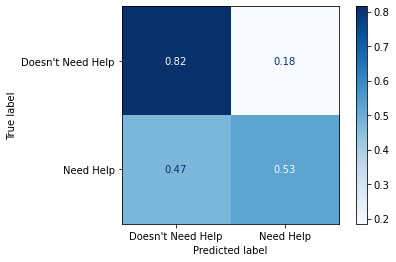

In [88]:
evaluate(gridsearch_cb,X_train,y_train,X_val,y_val)

Gridsearching gave us a overfitted model.

### Evaluation

Our best predictive model so far is the catboost model with feature selection.

Accuracy Score:
Train - 0.7654927654927655
Test - 0.6934889434889435
  
Precision Score:
Train - 0.7592039800995025
Test - 0.6108597285067874
  
Recall Score: 
Train - 0.5528985507246377
Test - 0.45226130653266333
  
F1 Score: 
Train - 0.639832285115304
Test - 0.5197305101058711
  
ROC_AUC: 
Train - 0.72344883734217
Test - 0.6427164922576022
  
  
Confusion matrix for test data


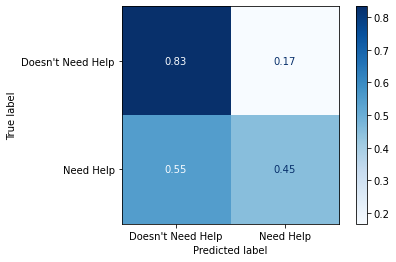

In [89]:
# evaluate final model on test set
evaluate(new_cb, X_train, y_train, X_test, y_test)

The model performance is consistent across training, testing and validation set. The model is not overfitted. Now let's look at feature importance.

In [90]:
# get feature importance for final model
new_cb.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Q15.m,28.936742
1,Q30.a,23.135176
2,Q54:4,17.194360
3,Q31,16.806516
4,Q41,13.927206
...,...,...
221,Q59:1,0.000000
222,Q59:2,0.000000
223,Q59:3,0.000000
224,Q59:4,0.000000


The the top 4 features are overwhelmingly more important than the rest. Let's see what they are.

In [91]:
info('Q15.m')

column name: Q15.m
     
Question: Concern about my mental health as a result of PhD study
     
number of null values: 3068
     
Value Count:
3rd                                                        510
2nd                                                        490
4th                                                        452
5th                                                        416
1st                                                        366
6th                                                        296
7th                                                        246
8th                                                        195
9th                                                        121
10th                                                       118
11th                                                        87
12th                                                        78
13th                                                        41
14th                                 

How concerned a student is when they go into a PhD program is a strong predictor of how likely they are going to ask for help for anxiety and depression. The reason could be if the student is very concerned about their mental health, they are more mental health conscious, therefore better at recognizing when they need to ask for help. Or it could be that a student who already has a vulnerability to mental health issues would be more concerned about it.

This is a innate quality of the student, not environmental. There's nothing the school can do about it so we will not focus on that.

In [92]:
info('Q30.a')

column name: Q30.a
     
Question: Mental health and wellbeing services in my university are tailored and appropriate to the needs of PhD students
     
number of null values: 20
     
Value Count:
Neither agree nor disagree                                                                                         1667
Somewhat disagree                                                                                                  1459
Somewhat agree                                                                                                     1436
Strongly disagree                                                                                                  1296
Strongly agree                                                                                                      482
Prefer not to say                                                                                                   152
Mental health and wellbeing services in my university are tailored and appropriate

If the university have better mental health services students are more likely to reach out for help. 

In [93]:
info('Q54:4')

column name: Q54:4
     
Question: What would you do differently right now if you were starting your programme? 
     
number of null values: 3559
     
Value Count:
Nothing                                                                          2953
What would you do differently right now if you were starting your programme?        1
Name: Q54:4, dtype: int64


This column is either nothing or null. The ones who have nothing they would do differently are more likely to have better mental health, because they have no regrets. But the ones who wrote down something they want to do differently would be the ones that have null values in this column. That makes a lot of sense, but also the schools can't do anything about it.

In [94]:
info('Q31')

column name: Q31
     
Question: Do you feel that you have experienced bullying in your PhD program?
     
number of null values: 7
     
Value Count:
No                                                                     4902
Yes                                                                    1388
Prefer not to say                                                       215
Do you feel that you have experienced bullying in your PhD program?       1
Name: Q31, dtype: int64


Bullying is a strong factor in needing mental health help. This result is very consistent with our inferential model.

Our logistic regression shows that a student is twice as likely to seek help if they are bullied VS if they are not bullied. That means if student A normally has 20% likelihood of seeking mental health help. He gets bullied the next day, his likelihood of seeking help will rise to 40%. That is quite a strong impact.

If we look deeper into this issue, we can see that nearly half are bullied by their supervisors, who hold a lot of power over their life and their future. 

![perpetrator](images/perpetrator.png)

Which explains why 57% of the students feel unable to speak out about their experience, fearing retaliation. 

![silence](images/silence.png)

(These two images are from the [EDA report by the surveyer](https://figshare.com/s/74a5ea79d76ad66a8af8?file=18543281) that I mentioned before.)


#### Score Evaluation

- Our model has an accuracy of 70%.

- Our model has a recall of 0.43, which means out of all the students who need mental health help, 42% will be caught by our model, 57% will fall through the crack.

- Even though this is not very accurate , it is still way better than not doing anything.

## Conclusions

### Recommendations:
- Hammer down on bullying
- Automate student mental health monitoring procedure with predictive model
- Work with mental health professionals to develop better questions for survey

Both our logistic regression and decision tree model indicates that whether a student is bullied in school is the biggest indicator of whether they would need help with anxiety and depression. Our more complicated catboost model confirms that it is the most important enironmental contributor to student mental health problems.

It's very hard for students to voice their concerns in school because in a lot of cases their bully is their supervisor. By having an automated procedure in place, student can be best protected against their bullies. They will be able to speak out without fear of retaliation and still get the help they need.

According to Stanford's [statistics](https://irds.stanford.edu/data-findings/doctoral-degree-programs-enrollment-and-demographics), there are 4720 new PhD students enrolled in 2021. Even though our model's predictive power is limited, it's going to be able to pick out 43% of the 36% of students who needs help with anxiety and depression, that's 730 students who gets the attention and care they need instead of suffering in silence. 